Inspired by [paper](https://www.researchgate.net/publication/237135894_A_unifying_framework_for_complexity_measures_of_finite_systems)

In this notebook I will implement TSE and Excess Entropy calculation and test it on following datasets:



1.   Wikipedia
2.   Simple English Wikipedia


# Preparation

In [214]:
!python3 -m pip install sentencepiece > /dev/null && echo 'OK'

OK


In [215]:
!python3 -m pip install tensorflow_text > /dev/null && echo 'OK'

OK


In [216]:
!python3 -m pip install tensorflow_datasets > /dev/null && echo 'OK'

OK


In [217]:
!python3 -m pip install tf_sentencepiece > /dev/null && echo 'OK'

OK


### Imports

In [218]:
import sentencepiece as spm
import tensorflow_datasets as tfds
from tqdm.notebook import tqdm
import numpy as np
from typing import List, Tuple
import nltk
import matplotlib.pyplot as plt

# Datasets

## Wikipedia

[link](https://www.tensorflow.org/datasets/catalog/wiki40b#wiki40ben_default_config) to dataset

In [219]:
ds = tfds.load('wiki40b/en', split='train', shuffle_files=True)

In [220]:
MAX_TEXTS_SIZE = 1000

texts = []
for x in ds:
    if len(texts) > MAX_TEXTS_SIZE:
        break
    s = x['text'].numpy().decode('utf-8')
    text = s.replace('_NEWLINE_', ' ').replace('_START_ARTICLE_', '').replace('_START_PARAGRAPH_', '').replace('_START_SECTION_',' ').split('\n')
    texts += list(filter(lambda x: len(x) > 20, text))

In [221]:
with open('train_text.txt', 'w') as fout:
    for text in texts:
        fout.write(text)
        fout.write('\n')

In [222]:
spm.SentencePieceTrainer.train('--input=train_text.txt --model_prefix=m --vocab_size=500')

In [223]:
sp = spm.SentencePieceProcessor()
sp.load('m.model')

True

In [224]:
print(list(sp.id_to_piece(i) for i in range(sp.vocab_size())))
print(sp.vocab_size())

['<unk>', '<s>', '</s>', 's', '▁', 'e', '▁the', ',', 't', '.', 'o', 'ed', '▁of', 'i', 'a', 'n', '▁in', 'u', 'y', '▁and', '▁a', 'd', 'er', 'ing', 'p', 'r', 'al', 'c', '▁to', 'm', 'ar', 'g', 'or', 'l', 'b', 'in', 'an', 'on', 'le', '▁c', 're', 'h', 'k', 'f', '▁m', 'th', '▁S', 'ic', 'en', '▁f', 'ch', 'it', '▁A', '▁was', '-', 'ri', '▁The', 'es', 'ra', 'at', '▁C', '▁B', 'ro', '▁re', 'v', '▁b', 'w', 'ad', '1', 'st', '▁P', 'il', '▁for', 'ur', '▁M', 'ation', 'ter', 'ly', '▁be', "'", ')', '▁(', '▁F', '▁w', 'ent', '▁on', '▁with', 'as', 'ion', 'am', 'ir', '▁as', 'ol', 'et', 'se', '▁st', '▁19', '▁T', 'us', 'ct', '▁H', '▁p', '▁is', '▁D', '▁by', 'ow', '5', '▁h', 'ul', '▁t', 'un', 'el', '3', '▁d', '▁de', '0', '9', '▁In', 'z', '▁G', 'is', '▁g', 'ac', 'lo', '▁from', 'ne', '7', '▁l', '4', 'tion', '▁con', '▁E', '6', 'ist', 'ive', 'li', '▁W', 'om', '▁L', '▁he', '2', 'ment', 'ver', '▁that', 'ate', '▁at', '"', '8', '▁his', 'im', '▁an', '▁J', 'ce', 'vi', '▁1', 'ci', '▁2', '▁R', 'ig', 'ge', 'qu', 'and', '▁"', 

In [225]:
print(sp.encode_as_ids('Hello, my friend'))
print(sp.encode_as_pieces('Hello, my friend'))

[100, 270, 10, 7, 44, 18, 49, 55, 48, 21]
['▁H', 'ell', 'o', ',', '▁m', 'y', '▁f', 'ri', 'en', 'd']


In [226]:
def collect_statistics(
    texts: List[str], 
    sp: spm.SentencePieceProcessor
) -> Tuple[np.ndarray]:
    """
    texts: the list of str texts
    sp: pretrained sentencepieces tokenizer

    Returns
    - a nltk.FreqDist with counts for (i, (x_{i-1}, x_i))
    - a nltk.FreqDist with counts for (i, x_i)
    - a nltk.FreqDist with counts for (i, x_i), where i is the last position of the sequence
    - a nltk.FreqDist with counts for i - the number of texts with i-th position
    """

    vocab_size = sp.vocab_size()
    bins = np.arange(vocab_size + 1)

    F_pair = nltk.FreqDist()
    F_single = nltk.FreqDist()
    F_last = nltk.FreqDist()
    F_pos = nltk.FreqDist()

    for text in tqdm(texts):
        tokenized_sequence = sp.encode_as_ids(text)
        bgs = nltk.bigrams(tokenized_sequence)
        F_pair += nltk.FreqDist(zip(range(1, len(tokenized_sequence)), bgs))
        F_single += nltk.FreqDist(zip(range(len(tokenized_sequence)), tokenized_sequence))
        F_last += nltk.FreqDist([(len(tokenized_sequence) - 1, tokenized_sequence[-1])])
        F_pos += nltk.FreqDist(range(len(tokenized_sequence)))
    
    return F_pair, F_single, F_last, F_pos

In [227]:
F_pair, F_single, F_last, F_pos = collect_statistics(texts, sp)

## Simple English wikipedia

some [link](https://github.com/LGDoor/Dump-of-Simple-English-Wiki)

In [228]:
!git clone https://github.com/LGDoor/Dump-of-Simple-English-Wiki.git

fatal: destination path 'Dump-of-Simple-English-Wiki' already exists and is not an empty directory.


In [229]:
!tar -xf Dump-of-Simple-English-Wiki/corpus.tgz

In [230]:
!ls -lh

total 36M
-rw-r--r-- 1  501 staff  32M Apr  9  2013 corpus.txt
drwxr-xr-x 3 root root  4.0K Nov 20 19:31 Dump-of-Simple-English-Wiki
-rw-r--r-- 1 root root  239K Nov 20 21:05 m.model
-rw-r--r-- 1 root root  7.0K Nov 20 21:05 m.vocab
drwxr-xr-x 1 root root  4.0K Nov 13 17:33 sample_data
-rw-r--r-- 1 root root  2.5M Nov 20 20:02 simple_train_text.txt
-rw-r--r-- 1 root root  239K Nov 20 20:02 s.model
-rw-r--r-- 1 root root  7.1K Nov 20 20:02 s.vocab
-rw-r--r-- 1 root root  860K Nov 20 21:05 train_text.txt


In [231]:
SIMPLE_MAX_TEXTS_SIZE = 1000

simple_texts = []
with open('corpus.txt', 'r') as fin:
    for s in fin:
        if len(simple_texts) > SIMPLE_MAX_TEXTS_SIZE:
            break
        text = s.split('\n')
        simple_texts += list(filter(lambda x: len(x) > 20, text))

In [232]:
with open('simple_train_text.txt', 'w') as fout:
    for text in simple_texts:
        fout.write(text)
        fout.write('\n')

In [233]:
spm.SentencePieceTrainer.train('--input=simple_train_text.txt --model_prefix=s --vocab_size=500')

In [234]:
simple_sp = spm.SentencePieceProcessor()
simple_sp.load('s.model')

True

In [235]:
print(list(sp.id_to_piece(i) for i in range(sp.vocab_size())))
print(sp.vocab_size())

['<unk>', '<s>', '</s>', 's', '▁', 'e', '▁the', ',', 't', '.', 'o', 'ed', '▁of', 'i', 'a', 'n', '▁in', 'u', 'y', '▁and', '▁a', 'd', 'er', 'ing', 'p', 'r', 'al', 'c', '▁to', 'm', 'ar', 'g', 'or', 'l', 'b', 'in', 'an', 'on', 'le', '▁c', 're', 'h', 'k', 'f', '▁m', 'th', '▁S', 'ic', 'en', '▁f', 'ch', 'it', '▁A', '▁was', '-', 'ri', '▁The', 'es', 'ra', 'at', '▁C', '▁B', 'ro', '▁re', 'v', '▁b', 'w', 'ad', '1', 'st', '▁P', 'il', '▁for', 'ur', '▁M', 'ation', 'ter', 'ly', '▁be', "'", ')', '▁(', '▁F', '▁w', 'ent', '▁on', '▁with', 'as', 'ion', 'am', 'ir', '▁as', 'ol', 'et', 'se', '▁st', '▁19', '▁T', 'us', 'ct', '▁H', '▁p', '▁is', '▁D', '▁by', 'ow', '5', '▁h', 'ul', '▁t', 'un', 'el', '3', '▁d', '▁de', '0', '9', '▁In', 'z', '▁G', 'is', '▁g', 'ac', 'lo', '▁from', 'ne', '7', '▁l', '4', 'tion', '▁con', '▁E', '6', 'ist', 'ive', 'li', '▁W', 'om', '▁L', '▁he', '2', 'ment', 'ver', '▁that', 'ate', '▁at', '"', '8', '▁his', 'im', '▁an', '▁J', 'ce', 'vi', '▁1', 'ci', '▁2', '▁R', 'ig', 'ge', 'qu', 'and', '▁"', 

In [236]:
print(sp.encode_as_ids('Hello, my friend'))
print(sp.encode_as_pieces('Hello, my friend'))

[100, 270, 10, 7, 44, 18, 49, 55, 48, 21]
['▁H', 'ell', 'o', ',', '▁m', 'y', '▁f', 'ri', 'en', 'd']


In [237]:
simple_F_pair, simple_F_single, simple_F_last, simple_F_pos = collect_statistics(simple_texts, simple_sp)

# Calculating metrics

## Excess Entropy

Friendly reminder:

Suppose that we have a sequence of tokens $x_0, x_1, \ldots, x_{n-1}$.
We want to calculate $E(x_0, x_1, \ldots, x_{n-1})$

In original papers this metrics can be calculated only of some multidimensional random value, but not of sequence of numbers. 

So, $E(X_0, X_1, \ldots, X_{n-1}) = (n-1)\left(\frac{1}{n-1}\sum\limits_{i=0}^{n-1}H(X_0, X_1, \ldots, X_{i-1}, X_{i+1}, \ldots, X_{n-1}) - H(X_0, \ldots, X_{n-1})\right)$

The problem is how to calculate $H(\ldots)$ if we have only a sequence of numbers.

First of all, let's simplify the problem: we want to create such r.v. $\xi_i$ from our numbers in such a way that $H(\xi_0, \ldots, \xi_{n-1}) = H(\xi_0) + H(\xi_1|\xi_0) + \ldots + H(\xi_{n-1}|\xi_{n-2})$. How can we find such r.v.?

Notice that $\xi_i$ should depends on the position ($i$) in the sequence and on number at this position ($x_i$).

Let's construct r.v. by $x_i$. So, $x_i$ will generate r.v. $\xi^i_{x_i}$. What the distribution of such r.v. is?

* $p(\xi^0_{x_0}) = \frac{\#\text{sequences with $x_0$ at the very beginning}}{\#\text{of first positions}}$

* $p(\xi^i_{x_i}, \xi^{i-1}_{x_{i-1}}) = \frac{\#\text{sequences with $x_{i-1}$ at position $i-1$ and $x_i$ at position $x_i$}}{\#\text{sequences with $i$-th position}}$

Then we can define Excess Entropy of sequence of numbers

$E(x_0, \ldots, x_{n-1}) = E(\xi^0_{x_0}, \xi^1_{x_1}, \ldots, \xi^{n-1}_{x_{n-1}})$

How to calculate it efficiently?

Let's denote $\mu_i = \xi^i_{x_i}$

* $\hat{H} = H(\mu_0, \ldots, \mu_{n-1}) = H(\mu_0) + H(\mu_1|\mu_0) + \ldots + H(\mu_{n-1} | \mu_{n-2})$
    * $H(\mu_i) = -p(\mu_i)\log p(\mu_i) - (1-p(\mu_i))\log (1 - p(\mu_i))$
    * $H(\mu_i,\mu_{i-1}) = $ entropy of pair of binary r.v.
    * $H(\mu_i|\mu_{i-1}) = H(\mu_i, \mu_{i-1}) - H(\mu_{i-1})$
* $H(\mu_0, \ldots, \mu_{i-1}, \mu_{i+1}, \ldots, \mu_{n-1}) = \hat{H} - H(\mu_i|\mu_{i-1}) - H(\mu_{i+1}|\mu_i) + H(\mu_{i+1}|\mu_{i-1})$
$=\hat{H} - H(\mu_i|\mu_{i-1}) - H(\mu_{i+1}|\mu_i) + H(\mu_{i+1})$

So, we can easily calculate Excess Entropy in $O(n)$ time

**Note**: if we will define r.v. which depends only on values then we can not easily calculate Excess entropy, because there is dependency between all r.v.

**Note**: $E(x_0, \ldots, \mu_{n-1})=
\left[\sum\limits_{i=0}^{n-2}H(\mu_0, \ldots, \mu_i)\right] + 
\left[\sum\limits_{i=1}^{n-1}H(\mu_i, \ldots, \mu_{n-1})\right] - 
(n - 1) H(\mu_0, \ldots, \mu_{n-1})$, which is sum of Entropies for each prefix and for each suffix minus entropy of full text multiplied by $(n-1)$

**Note**: Let's rewrite the formula. 
$E(\mu_0, \ldots, \mu_{n-1}) = \hat{H} + \sum\limits_{i=0}^{n-1}\left[H(\mu_0,\ldots,\mu_{i-1},\mu_{i+1},\ldots,\mu_{n-1})-\hat{H}\right]=
\hat{H} + \sum\limits_{i=0}^{n-1}\left[-H(\mu_i|\mu_{i-1})-H(\mu_{i+1}|\mu_i)+H(\mu_{i+1})\right]=
\sum\limits_{i=0}^{n-1}\left[-H(\mu_i|\mu_{i-1})-H(\mu_{i+1}|\mu_i)+H(\mu_{i+1})+H(\mu_i|\mu_{i-1})\right]=
\sum\limits_{i=0}^{n-1}\left[H(\mu_{i+1})-H(\mu_{i+1}|\mu_i)\right]=
\sum\limits_{i=0}^{n-2}I(\mu_i\colon\mu_{i+1})$

**Note**: How can we calculate $H(\mu_i)$?
$H(\mu_i) = Entropy([p, 1 - p])$, where $p = \frac{\#(x_i,i)}{\#(i)}$

**Note**: How can we calculate $H(\mu_i, \mu_{i-1})$?
$H(\mu_i) = Entropy([p_{0,0}, p_{0,1}, p_{1, 0}, p_{1,1}])$, where 
* $p_{1,1} = \frac{\#(i,x_i,x_{i-1})}{\#(i)}$
* $p_{1,0} = \frac{\#(i,x_i,\overline{x_{i-1}})}{\#(i)}$
* $p_{0,1} = \frac{\#(i,\overline{x_i},x_{i-1})}{\#(i)}$
* $p_{0,0} = \frac{\#(i,\overline{x_i},\overline{x_{i-1}})}{\#(i)}$

In [288]:
def calculate_excess_entropy(
    texts: List[str], 
    sp: spm.SentencePieceProcessor,
    F_pair: nltk.FreqDist,
    F_single: nltk.FreqDist,
    F_last: nltk.FreqDist,
    F_pos: nltk.FreqDist
) -> np.ndarray:
    """
    texts: the list of str texts
    sp: pretrained sentencepieces tokenizer
    F_pair: nltk.FreqDist with counts for (i, (x_{i-1}, x_i))
    F_single: nltk.FreqDist with counts for (i, x_i)
    F_last: nltk.FreqDist with counts for (i, x_i), where i is the last position of the sequence
    F_pos: nltk.FreqDist with counts for i - the number of texts with i-th position
    
    Returns
    - a (# of texts,) numpy array with excess entropy calculated for each text
    """

    EPS = 1e-9
    def calculate_entropy(p):
        assert 0 <= p.min() <= p.max() <= 1
        assert abs(p.sum() - 1) < EPS
        return np.sum(-p * np.log(np.clip(p, EPS, 1 - EPS)))

    def H_single(i, xi, verbose: bool = False):
        p = F_single[(i, xi)] / F_pos[i]
        if verbose:
            print(p)
        return calculate_entropy(np.array([1 - p, p]))

    def H_pair(i, prev, cur, verbose: bool = False):
        # p = F_pair[(i, (prev, cur))] / F_pos[i]
        # if verbose:
        #     print(p)
        # return calculate_entropy(p) - H_single(i - 1, prev)
        T = F_pos[i]
        c11 = F_pair[(i, (prev, cur))]
        c1_ = F_single[(i - 1, prev)] - F_last[(i - 1, prev)]
        c_1 = F_single[(i, cur)]
        c10 = c1_ - c11
        c01 = c_1 - c11
        c00 = T - c11 - c01 - c10
        p = np.array([c00, c01, c10, c11]) / T
        return calculate_entropy(p) - calculate_entropy(p.reshape(2, 2).sum(axis=1))

    ee = np.zeros(len(texts), dtype=float)

    for id, text in tqdm(enumerate(texts)):
        x = sp.encode_as_ids(text)
        n = len(x)
        H_hat = 0
        
        delta = 0
        for i in range(n):
            if i == 0:
                H_hat += H_single(0, x[i])
            # else:
                # H_hat += H_pair(i, x[i - 1], x[i])
            # if i > 0:
                # delta += -H_pair(i, x[i - 1], x[i])
            if i + 1 < n:
                delta += -H_pair(i + 1, x[i], x[i + 1]) + H_single(i + 1, x[i + 1])
        ee[id] = delta + H_hat

    return ee

In [289]:
ee = calculate_excess_entropy(
    texts,
    sp,
    F_pair,
    F_single,
    F_last,
    F_pos
)

In [290]:
print(ee.min(), ee.max(), ee.mean(), ee.std())

0.03562021464255295 2199.858353792161 16.832806555205096 123.27993772947532


In [291]:
lens = np.array([len(sp.encode_as_ids(text)) for text in texts])

In [292]:
simple_ee = calculate_excess_entropy(
    simple_texts,
    simple_sp,
    simple_F_pair,
    simple_F_single,
    simple_F_last,
    simple_F_pos
)

In [293]:
print(simple_ee.min(), simple_ee.max(), simple_ee.mean(), simple_ee.std())

0.0303073759730538 89.79308075849626 1.8753788898524364 5.543293007895409


In [294]:
simple_lens = np.array([len(sp.encode_as_ids(text)) for text in simple_texts])

''

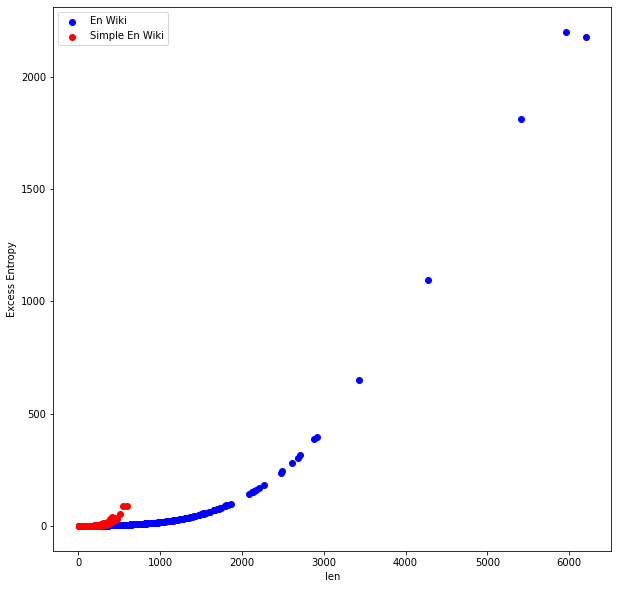

In [295]:
plt.figure(figsize=(10, 10))
plt.xlabel('len')
plt.ylabel('Excess Entropy')
plt.scatter(lens, ee, color='blue', label='En Wiki')
plt.scatter(simple_lens, simple_ee, color='red', label='Simple En Wiki')
plt.legend()
;

## TSE Complexity

We have sequence of numbers (tokens): $x_0, \ldots, x_{n-1}$

Let's denote 
* $V_i = \{0, 1, \ldots, i\}$
* $V = V_{n-1}$
* $\mu_A = \mu_{i_0}, \mu_{i_1}, \ldots, \mu_{i_{k-1}}$, where $A = \{i_0, i_1, \ldots, i_{k-1}\}$ and $i_{j} < i_{j+1}$


TSE Complexity is $C(\mu_V) = \sum\limits_{k=1}^{n-1}\frac{k}{n}C^{(k)}(\mu_V)$, where

$C^{(k)}(\mu_V) = \left[\frac{n}{k}\cdot\frac{1}{\binom{n}{k}}\sum\limits_{A\subset V, |A| = k}H(\mu_A)\right] - H(\mu_V)$

We already know, how to calculate $H(\mu_V)$.

How can we calculate left term of given formula. Let's use dynamic programming, which allows us to do it in $O(n^2)$ time complexity.

Let's define 

* $d(i, k) = \frac{1}{\binom{i}{k}}\sum\limits_{A\subset V_i, |A| = k} H(\mu_A)$, 

    where $0 \le i < n, 0 \le k < n$

* $d(i, 0) = 0$

    $\forall 0 \le i < n$

then 

* $C^{(k)}(\mu_V) = \frac{n}{k}d(n - 1, k) - H(\mu_V)$
    
    $C(\mu_V) = \sum\limits_{k=1}^{n-1}\left(d(n - 1, k) - \frac{k}{n}H(\mu_v)\right) = \left[\sum\limits_{k=1}^{n-1}d(n-1,k)\right] - \frac{n-1}{2}H(\mu_V)$

Transition:

$d(i, k) = \frac{1}{\binom{i+1}{k}}\sum\limits_{A\subset V_i, |A| = k} H(\mu_A) =$

$=\left[\frac{1}{\binom{i+1}{k}}\sum\limits_{A\subset V_{i-1}, |A| = k} H(\mu_A)\right]
+ \left[\frac{1}{\binom{i+1}{k}}\sum\limits_{A\subset V_{i-1}, |A| = k-1,} H(\mu_{A\cup\{i\}})\right]
=$

$=\left[\frac{1}{\binom{i+1}{k}}\sum\limits_{A\subset V_{i-1}, |A| = k} H(\mu_A)\right]
+ \left[\frac{1}{\binom{i+1}{k}}\sum\limits_{A\subset V_{i-2}, |A|=k-1}H(\mu_{A\cup\{i\}})\right]
+ \left[\frac{1}{\binom{i+1}{k}}\sum\limits_{A\subset V_{i-2}, |A|=k-2}H(\mu_{A\cup\{i-1,i\}})\right] = A + B + C$

Let's introduce two definitions
1. $d^0(i, k) = \frac{1}{\binom{i+1}{k}}\sum\limits_{A\subset V_{i-1},|A|=k}H(\mu_A)$. 
    
    $d^0(i, 0) = 0$
2. $d^1(i, k) = \frac{1}{\binom{i+1}{k}}\sum\limits_{A\subset V_{i-1},|A|=k-1}H(\mu_{A\cup{\{i\}}})$. 
    
    $d^1(i, 0) = 0$

then we have 
* $d(i, k) = d^0(i, k) + d^1(i, k)$
* $d^0(i, k) = d(i - 1, k)$

Then if $i > 0$

* $A = \frac{i-k+1}{i+1}d(i-1,k)$

* $B = \frac{1}{\binom{i+1}{k}}\sum\limits_{A\subset V_{i-2},|A|=k-1}\left[H(\mu_A) + H(\mu_i)\right] = \left[\frac{1}{\binom{i+1}{k}}\sum\limits_{A\subset V_{i-2},|A|=k-1}H(\mu_A)\right] + \frac{\binom{i-1}{k-1}}{\binom{i+1}{k}}H(\mu_i) =$

$= \frac{i-k+1}{i+1}d^0(i-1,k-1) + \frac{k(i-k+1)}{i(i+1)}H(\mu_i)$

* $C = \frac{1}{\binom{i+1}{k}}\sum\limits_{A\subset V_{i-2}, |A|=k-2}\left[H(\mu_{A\cup\{i-1\}}) + H(\mu_i|\mu_{i-1})\right] = \frac{i-k+1}{i+1}d^1(i-1,k-1) + \frac{\binom{i-1}{k-2}}{\binom{i+1}{k}}H(\mu_i|\mu_{i-1}) = $

$=\frac{i-k+1}{i+1}d^1(i-1,k-1) + \frac{k(k-1)}{i(i+1)}H(\mu_i|\mu_{i-1})$

**Note**: $\binom{i}{k}=\frac{i!}{k!(i-k)!}=\frac{(i-1)!i}{k!(i-1-k)!(i-k)}=\binom{i-1}{k}\frac{i}{i-k}$

if $i = 0$ then 
* $d(0, 1) = H(\mu_0)$
* $d(0, k) = 0$

    $\forall k > 1$
